# Notebook 2: Training the model

#### **TL;DR**
In this part of training the object detection model, designed to recognize **10 different species** of houseplants, will train using a **pre-trained YOLOv8 model**. Initially, the model exhibited signs of overfitting, performing exceptionally well on the training data but poorly on validation data. To address this, I incorporated **data augmentations** such as rotations, flips, brightness adjustments, and other transformations tailored to plant images. These augmentations enhanced the model's robustness and generalization, helping to reduce overfitting and improve validation accuracy across all plant species.

# Imports and definitions

In [ ]:
!pip install ultralytics

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from ultralytics import YOLO
from PIL import Image, ImageOps
import yaml
import random
import os

%matplotlib inline


In [ ]:
drive.mount('/content/drive')
BASE_PATH = '/content/drive/MyDrive/Plant Recognition/Model/'

# Define paths for train and valid
TRAIN_IMAGES_PATH = os.path.join(BASE_PATH, 'dataset/images/train')
VAL_IMAGES_PATH = os.path.join(BASE_PATH, 'dataset/images/val')
TRAIN_LABELS_PATH = os.path.join(BASE_PATH, 'dataset/labels/train')
VAL_LABELS_PATH = os.path.join(BASE_PATH, 'dataset/labels/val')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
plants = [
    "Aloe Vera",
    "Tradescantia",
    "Snake plant (Sanseviera)",
    "Peace lily",
    "Orchid",
    "Monstera Deliciosa (Monstera deliciosa)",
    "Echeveria",
    "Ctenanthe",
    "Chinese Money Plant (Pilea peperomioides)",
    "African Violet (Saintpaulia ionantha)"
]

# Choice of the YOLO Model

I faced a challenging decision between using a single-shot detector (SSD) and a two-shot detector for our object detection project. While SSD is known for its **speed and efficiency** since it predicts the bounding box and the class of the object in one single shot, The two-shot detector offers **higher accuracy** at the cost of increased computational resources and longer processing times.

Given my limited resources on Google Colab, and the short time available for this task, I prioritized efficiency and speed and chose the **YOLO model**.

#### YOLO (You Only Look Once)
Is a state-of-the-art, real-time object detection system that divides images into grids and predicts bounding boxes and class probabilities for each grid cell. This allows YOLO to process images quickly and accurately.

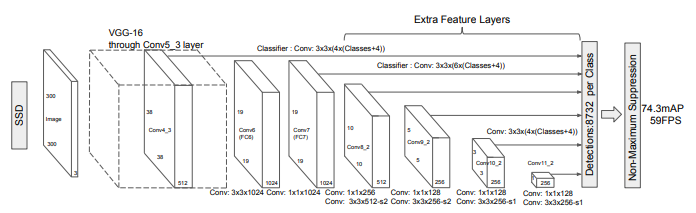

# Framework Selection
Through brief research, we discovered that the **Ultralytics framework** is the best option for implementing YOLO due to its specialization and ease of use.

# Training with YOLOv8 model and Ultralytics framework

### YOLO configuration file

An important note about **class_weights** parameter, it was adjusted to **emphasize underperforming classes** like Peace Lily and African Violet by assigning them higher weights in the training process. This helps balance the model's attention towards these classes, which are harder to classify.

In [ ]:
# Define the dataset paths and class names in the YAML file
dataset_yaml = {
    'path': BASE_PATH,
    'train': 'dataset/images/train',
    'val': 'dataset/images/val',
    'nc': 10,
    'names': plants,  # class names
    'class_weights': [1, 2, 1, 3, 3, 1, 1, 1, 1, 4],  # Higher weights for Peace Lily and African Violet
    'albumentations': 1
}

# Write to a YAML file
yaml_file = os.path.join(BASE_PATH, 'mydataset.yaml')
with open(yaml_file, 'w') as file:
    yaml.dump(dataset_yaml, file, default_flow_style=False)

print(f'YAML file created: {yaml_file}')

YAML file created: /content/drive/MyDrive/Studying/Computer Science - Final Project/Model/mydataset.yaml


# Training with Augmentations

Running YOLOv8 with augmentations enhances the dataset by introducing diverse variations that **simulate real-life scenarios and challenging conditions**. Augmentations help the model generalize better to various lighting, angles, and object occlusions, ultimately improving its robustness and detection capabilities.
I applied specific augmentations tailored to the unique characteristics of plants and flowers, such as **variations in lighting**, **color intensity**, **orientation**, and **partial visibility**.

YOLOv8 includes **built-in** functionality for augmentations, which can be configured in the train section of the YAML file.

### Learning parameters
* **epochs** - Set to 120. Since the dataset has almost 3K images with some complex classes.
* **lr0** - Set to 0.0005. Initial learning rate for the optimizer, providing a balance between speed and stability in learning.
* **lrf** - Set to 0.01. Final learning rate fraction, ensuring smoother convergence towards the end of training.
* **batch** - Set to 128. Batch size determines how many samples are processed together in one forward/backward pass.
* **weight_decay** - Set to 1e-3. Regularization parameter to prevent overfitting by penalizing large weights.
* **patience** - Set to 20. Early stopping parameter to halt training if validation performance stagnates for 20 epochs.
* **dropout** - Set to 0.2. Adds noise to the model by randomly disabling neurons during training, improving generalization.
* **warmup_epochs** - Set to 3. Gradually increases the learning rate at the start of training to stabilize optimization.
* **optimizer** - AdamW is used for its balance of convergence speed and robustness.
* **conf** - Set to 0.3. Minimum confidence for predictions to be considered valid.

### Augmentation parameters
* **hsv_h** - Set to 0.2. Helps the model generalize across different lighting conditions.
* **hsv_s** - Set to 0.8. Useful for plants with diverse colors.
* **hsv_v** - Set to 0.8. Helping the model to perform well under various lighting conditions, especially for diverse flowers.
* **degrees** - Set to 20.0. Improving the model's ability to recognize objects at various orientations.
* **scale** - Set to 0.8. Adds scaling variations for robustness.
* **shear** - Set to 0.5. Mimicking the effect of objects being viewed from different angles.
* **perspective** - Set to 0.001. Enhancing the model's ability to understand objects in 3D space.
* **flipud** - Set to 0.2. Increasing the data variability without affecting the object's characteristics.
* **fliplr** - Set to 0.4. Useful for learning symmetrical objects and increasing dataset diversity.
* **mosaic** - Set to 0.8. Combines four different images into one, enhancing object detection under varied scene conditions.
* **mixup** - Set to 0.8. Blends two images and their labels, improving the model's robustness to variations in input.
* **erasing** - Set to 0.1. Randomly erases parts of images, helping the model recognize objects even when partially obscured.
* **crop_fraction** - Set to 0.15. Crops small portions of images, teaching the model to identify objects that are not fully visible.
* **close_mosaic** - Set to 50. Ensures mosaics use recent samples for training stability.
* **auto_augment** - Set to 'randaugment'. Applies random augmentation strategies to improve variability.


**Load the pre-trained YOLOv8n model and train with augmentations**

In [ ]:
# Load a pretrained YOLO model
yolo_model = YOLO("yolov8n.pt")

results = yolo_model.train(data=yaml_file, epochs=120, lr0=0.0005, lrf=0.01, label_smoothing=0.1,
                           batch=128, weight_decay=1e-3, patience=20, dropout=0.2, warmup_epochs=3,
                           cos_lr=True, device='cuda:0', conf=0.3, optimizer='AdamW',
                           augment=True, warmup_momentum=0.8, hsv_h=0.2, hsv_s=0.8, hsv_v=0.8,
                           degrees=20.0, scale=0.8, shear=0.5, perspective=0.001, crop_fraction=0.15,
                           flipud=0.2, fliplr=0.4, mosaic=0.8, mixup=0.8, erasing=0.1,
                           close_mosaic=50, auto_augment='randaugment', save_period=20)

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Studying/Computer Science - Final Project/Model/mydataset.yaml, epochs=120, time=None, patience=20, batch=128, imgsz=640, save=True, save_period=20, cache=False, device=cuda:0, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=50, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=0.3, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, r

train: Scanning /content/drive/MyDrive/Studying/Computer Science - Final Project/Model/dataset/labels/train.cache... 2433 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2433/2433 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Studying/Computer Science - Final Project/Model/dataset/labels/val.cache... 616 images, 0 backgrounds, 0 corrupt: 100%|██████████| 616/616 [00:00<?, ?it/s]


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.002), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train10
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      17.3G      1.768      3.686      2.168          5        640: 100%|██████████| 20/20 [00:51<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all        616        616          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      17.2G      1.326       3.18      1.868          6        640: 100%|██████████| 20/20 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all        616        616          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      17.3G      1.266      2.886      1.824          3        640: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all        616        616      0.315     0.0594      0.184      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      17.3G      1.277      2.634      1.819          5        640: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        616        616      0.198      0.376      0.235      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      17.9G      1.269      2.509      1.806          2        640: 100%|██████████| 20/20 [00:20<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.379      0.367       0.34      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      17.9G       1.27      2.455      1.813          5        640: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.329      0.511      0.402      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      17.3G      1.235      2.343      1.777          4        640: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all        616        616      0.563      0.479      0.516      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      17.3G      1.268      2.331      1.784          5        640: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all        616        616      0.629      0.323      0.471      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      17.3G      1.264      2.243      1.782          5        640: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all        616        616      0.556      0.469      0.509      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      17.3G      1.224      2.307      1.729          1        640: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all        616        616      0.609      0.538      0.572      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      17.9G      1.225      2.142      1.756          4        640: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all        616        616      0.447      0.484      0.434       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      17.9G       1.21      2.074       1.72          4        640: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        616        616      0.753      0.506      0.649      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      17.9G      1.196      2.043      1.713          6        640: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all        616        616       0.56      0.542      0.562      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      17.3G      1.157      2.092      1.727          1        640: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all        616        616      0.657      0.627      0.677      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      17.3G      1.196       2.02      1.721          3        640: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all        616        616      0.756      0.697      0.741      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      17.3G      1.141      1.967      1.694          2        640: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.704      0.706       0.75      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      17.9G      1.157      1.878      1.688          8        640: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        616        616      0.649      0.613      0.648      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      17.3G      1.202      1.948      1.719          5        640: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.625      0.667      0.676      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      17.9G      1.165      1.907      1.691          8        640: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all        616        616      0.704      0.619       0.69      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      17.3G      1.155      1.891       1.66          5        640: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all        616        616      0.725      0.655      0.712      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      17.3G      1.159      1.849      1.681          6        640: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        616        616      0.738      0.699       0.75      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      17.3G      1.101      1.839       1.64          2        640: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.722      0.679      0.715      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      17.3G       1.13      1.791      1.657          4        640: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all        616        616      0.688      0.607      0.657      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      17.3G      1.152       1.83       1.68          3        640: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        616        616      0.759      0.671      0.747      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      17.9G      1.091      1.751       1.62          4        640: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        616        616      0.725      0.703      0.743      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      17.9G      1.119      1.788      1.663          3        640: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all        616        616      0.736      0.674      0.738      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      17.9G      1.114      1.794      1.636          5        640: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all        616        616      0.744       0.68      0.723      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      17.3G      1.146      1.742      1.663          6        640: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.734      0.717      0.778      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      17.9G      1.122      1.811      1.641          3        640: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all        616        616      0.655      0.698      0.712      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      17.3G      1.151       1.83      1.663          4        640: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        616        616      0.729      0.694      0.749      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      17.3G      1.112      1.704      1.622          6        640: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        616        616      0.771      0.678      0.749      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      17.3G      1.096      1.694      1.622          5        640: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.772      0.687      0.752      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      17.3G      1.138      1.746      1.627          1        640: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.683      0.663      0.704      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      17.3G      1.093      1.703      1.628          6        640: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all        616        616      0.729      0.663      0.722      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      17.3G      1.093      1.625      1.624          4        640: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all        616        616      0.764      0.678       0.74      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      17.9G      1.107      1.679      1.647          4        640: 100%|██████████| 20/20 [00:15<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        616        616      0.727      0.753      0.781      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      17.9G      1.086      1.657      1.614          3        640: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        616        616      0.725      0.745      0.749      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      17.3G      1.109      1.638      1.639          4        640: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        616        616       0.67      0.673      0.691      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      17.9G      1.076       1.64      1.601          6        640: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.662      0.744      0.735      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      17.3G       1.07      1.737      1.625          1        640: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        616        616      0.731      0.738      0.766      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      17.3G      1.051      1.584      1.597          4        640: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        616        616      0.765      0.755      0.792      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      17.3G      1.068      1.585      1.584          5        640: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        616        616      0.702      0.751      0.773       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      17.3G      1.044      1.596      1.584          7        640: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.806      0.738       0.81      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      17.9G      1.083      1.608      1.605          4        640: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.799      0.746      0.798      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      17.9G      1.091      1.631      1.589          4        640: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        616        616      0.749      0.692      0.736       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      17.3G      1.046      1.544      1.564          4        640: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.769      0.706      0.771       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      17.3G      1.094      1.623      1.611          7        640: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all        616        616      0.781      0.755      0.789      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      17.3G      1.052      1.517      1.567          4        640: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all        616        616      0.827      0.769      0.818      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      17.3G      1.073      1.567      1.577          5        640: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.788      0.771      0.809      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      17.3G      1.026       1.55      1.565          5        640: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        616        616      0.762      0.744       0.79      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      17.9G      1.054      1.612      1.593          5        640: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.781      0.742      0.803       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      17.9G      1.048      1.526       1.59          7        640: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.817      0.769       0.82      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      17.9G      1.068      1.627      1.596          3        640: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.774       0.75      0.801       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      17.9G      1.133      1.654      1.684          1        640: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.777      0.804      0.818      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      17.9G      1.025       1.51      1.555          5        640: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all        616        616      0.801      0.776      0.809       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      17.9G     0.9861      1.473      1.526          4        640: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.783      0.786      0.826      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      17.9G      1.029      1.465      1.574          8        640: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        616        616      0.789       0.79       0.83      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      17.9G      1.073      1.497      1.618          2        640: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.754      0.773      0.816      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      17.9G      1.026      1.509       1.58          6        640: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.784      0.758      0.816      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      17.9G      1.022      1.479      1.568          3        640: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.775      0.801      0.839      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      17.9G      1.077      1.499      1.601          1        640: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616       0.73      0.809      0.799      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      17.3G      1.044      1.501      1.584          8        640: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.767      0.792      0.816      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      17.3G      1.033      1.465      1.562          5        640: 100%|██████████| 20/20 [00:21<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.759      0.794      0.811      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      17.9G      1.017       1.42       1.55          6        640: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        616        616      0.766      0.805      0.823      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      17.9G     0.9942      1.458      1.516          1        640: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        616        616      0.731      0.787      0.795      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      17.9G      1.049      1.431      1.602          4        640: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.799      0.781      0.811      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      17.9G      1.031      1.437      1.555          8        640: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.754      0.798      0.818      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      17.9G      1.032      1.398      1.557          5        640: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        616        616      0.777      0.793      0.827      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      17.3G      1.021       1.46      1.551          6        640: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        616        616      0.817      0.751      0.829      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      17.3G      1.007      1.455      1.536          5        640: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        616        616      0.832       0.78      0.841       0.68


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      17.1G     0.6295       1.32      1.376          1        640: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.824      0.792      0.839      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      17.7G     0.5454     0.9378      1.245          0        640: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        616        616      0.816      0.765      0.826      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      17.1G     0.6027      1.026      1.334          1        640: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        616        616      0.857      0.781      0.849      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      17.7G     0.5415     0.8513      1.315          1        640: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all        616        616      0.838       0.82      0.858      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      17.7G     0.5572     0.7883      1.307          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.811      0.804      0.847       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      17.1G      0.562     0.7316      1.265          1        640: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.814      0.834      0.854      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120      17.7G     0.6326     0.9175      1.346          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616       0.81      0.812      0.846      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      17.7G      0.506     0.7488      1.258          1        640: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        616        616      0.818      0.829      0.849      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      17.7G      0.629     0.9181      1.382          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.815      0.816      0.846      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      17.7G     0.5449     0.7299      1.272          1        640: 100%|██████████| 20/20 [00:08<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.869      0.795      0.861       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      17.7G     0.5511      0.801      1.263          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.821      0.816       0.85      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      17.7G     0.6004     0.7491      1.355          1        640: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        616        616       0.86      0.794      0.864      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      17.1G     0.4856     0.7988      1.242          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.814      0.796      0.845      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      17.1G     0.5452     0.6897      1.268          1        640: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.825      0.811      0.853      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      17.7G     0.5054     0.7284       1.26          1        640: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        616        616      0.808      0.831      0.857      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      17.1G     0.5107     0.6975      1.247          1        640: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.837       0.81      0.848      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120      17.7G     0.4825     0.7409      1.231          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        616        616      0.843      0.793      0.853      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      17.1G     0.5239     0.7155      1.228          1        640: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.825      0.841      0.867      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      17.1G     0.4619     0.6728      1.157          0        640: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        616        616      0.845      0.802       0.85      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      17.1G     0.4544       0.72      1.211          1        640: 100%|██████████| 20/20 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.835      0.826      0.861       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120      17.1G     0.4736     0.6744      1.233          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616       0.84      0.828      0.864      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120      17.1G     0.5578     0.6404      1.242          1        640: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all        616        616      0.821       0.86      0.871      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      17.7G     0.4676     0.5873      1.224          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        616        616      0.846       0.83      0.863      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120      17.7G     0.4508     0.7038      1.198          1        640: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        616        616      0.837      0.841      0.866      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      17.7G     0.4698     0.6103      1.194          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        616        616      0.843      0.834      0.868      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      17.1G     0.5335     0.7397      1.248          1        640: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        616        616      0.865      0.819      0.871      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      17.1G     0.5127     0.5747      1.226          1        640: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        616        616      0.853      0.813       0.87      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      17.1G     0.4694     0.6681      1.178          1        640: 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        616        616      0.878      0.797       0.87      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      17.1G     0.4329     0.7277      1.191          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all        616        616      0.838      0.828      0.868      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120      17.1G     0.4684     0.5495       1.22          1        640: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        616        616      0.859      0.817      0.869      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      17.7G      0.475     0.6371      1.202          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.894      0.806      0.873      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      17.1G     0.4346     0.5992      1.191          1        640: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.891      0.793      0.869      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      17.1G     0.4801     0.7797      1.218          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.905      0.783      0.869      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      17.7G     0.5434     0.7017      1.303          1        640: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        616        616      0.872      0.791      0.867      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      17.1G      0.501     0.6657      1.281          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.847      0.817      0.869      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      17.1G     0.4778     0.6326      1.249          1        640: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.876      0.792      0.864      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      17.1G     0.4522     0.6483       1.18          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.841      0.827      0.871       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      17.1G     0.4356      0.575      1.188          1        640: 100%|██████████| 20/20 [00:08<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        616        616      0.879      0.797      0.871      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      17.1G     0.4561     0.6241      1.209          1        640: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        616        616      0.889      0.799      0.875      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      17.7G     0.5197     0.6071      1.201          1        640: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        616        616        0.9      0.796      0.869      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120      17.7G     0.5049     0.7344      1.234          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.894      0.785       0.87      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      17.1G      0.468     0.5979      1.177          1        640: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        616        616      0.869      0.805      0.869      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      17.1G     0.4171     0.6487       1.17          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        616        616      0.858      0.808      0.868      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      17.1G     0.4398     0.6261      1.187          1        640: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.867      0.807      0.869      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      17.1G      0.458     0.6124      1.191          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        616        616      0.876      0.795       0.87      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      17.1G     0.5066     0.5446      1.247          1        640: 100%|██████████| 20/20 [00:08<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.856      0.825      0.869      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      17.1G     0.4662     0.5326      1.221          1        640: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all        616        616      0.855       0.82       0.87      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      17.1G      0.415     0.5947      1.168          1        640: 100%|██████████| 20/20 [00:08<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        616        616      0.902       0.79       0.87      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      17.1G     0.4541       0.54      1.159          1        640: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        616        616      0.863      0.825      0.872      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      17.1G     0.4581      0.631      1.207          1        640: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        616        616      0.894      0.795      0.872      0.767



120 epochs completed in 0.636 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 6.2MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


                   all        616        616      0.892      0.787      0.871      0.794
             Aloe Vera         42         42          1      0.904      0.971      0.938
          Tradescantia         61         61      0.849      0.738      0.835      0.786
Snake plant (Sanseviera)         65         65      0.942      0.908      0.947       0.86
            Peace lily         87         87      0.831      0.564      0.752      0.637
                Orchid         60         60      0.801      0.583      0.767      0.665
Monstera Deliciosa (Monstera deliciosa)         60         60      0.933      0.967      0.975      0.931
             Echeveria         36         36       0.87      0.778      0.871      0.773
             Ctenanthe         61         61      0.966      0.984      0.987      0.955
Chinese Money Plant (Pilea peperomioides)         67         67      0.964       0.94      0.963       0.89
African Violet (Saintpaulia ionantha)         77         77      0.765  

**Mean Average Precision**

In [ ]:
results_train = yolo_model.val(data=yaml_file, batch=64, split='train')
results_val = yolo_model.val(data=yaml_file, batch=64)
print(f"The mean Average Precision (Train): {results_train.box.map:.2f}")
print(f"The mean Average Precision (Validation): {results_val.box.map:.2f}")

Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)


val: Scanning /content/drive/MyDrive/Studying/Computer Science - Final Project/Model/dataset/labels/train.cache... 2433 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2433/2433 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:39<00:00,  1.01s/it]


                   all       2433       2433      0.944      0.872      0.918      0.855
             Aloe Vera        166        166      0.964      0.964      0.978      0.941
          Tradescantia        242        242      0.901      0.793      0.857      0.808
Snake plant (Sanseviera)        262        262      0.981      0.966      0.981      0.905
            Peace lily        336        336      0.899      0.738      0.834      0.749
                Orchid        230        230      0.939        0.8      0.877      0.777
Monstera Deliciosa (Monstera deliciosa)        240        240      0.947      0.958      0.968       0.92
             Echeveria        146        146       0.94      0.863      0.916      0.864
             Ctenanthe        243        243      0.975      0.967      0.976      0.949
Chinese Money Plant (Pilea peperomioides)        270        270      0.971      0.978      0.982      0.913
African Violet (Saintpaulia ionantha)        298        298      0.923  

val: Scanning /content/drive/MyDrive/Studying/Computer Science - Final Project/Model/dataset/labels/val.cache... 616 images, 0 backgrounds, 0 corrupt: 100%|██████████| 616/616 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


                   all        616        616      0.919      0.776      0.859      0.793
             Aloe Vera         42         42          1      0.881       0.94      0.908
          Tradescantia         61         61      0.885      0.754       0.82      0.778
Snake plant (Sanseviera)         65         65      0.952      0.908      0.936      0.863
            Peace lily         87         87      0.849      0.517      0.704      0.628
                Orchid         60         60      0.875      0.583      0.766      0.686
Monstera Deliciosa (Monstera deliciosa)         60         60      0.951      0.967      0.969       0.92
             Echeveria         36         36        0.9       0.75      0.857      0.779
             Ctenanthe         61         61      0.967      0.967       0.98      0.945
Chinese Money Plant (Pilea peperomioides)         67         67      0.969       0.94      0.951      0.869
African Violet (Saintpaulia ionantha)         77         77      0.844  

**Model performance**

In [ ]:
# Extract mAP values
map_train = results_train.box.map
map_val = results_val.box.map

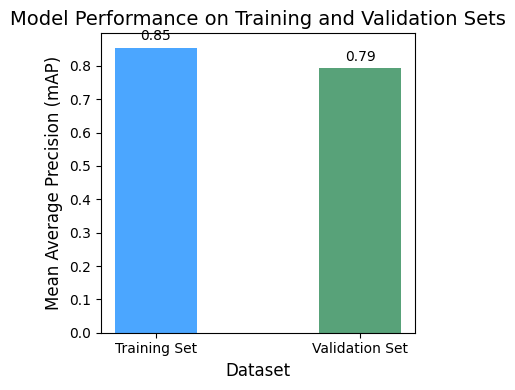

In [ ]:
# Visualization
groups = ['Training Set', 'Validation Set']
scores = [map_train, map_val]
x = list(range(len(groups)))  # x locations for the groups

fig, ax = plt.subplots(figsize=(4, 4))
bar_width = 0.4  # width of the bars
bars = ax.bar(x, scores, bar_width, color=['#1E90FF', '#2E8B57'], alpha=0.8)

# Adding labels, title, and ticks
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Mean Average Precision (mAP)', fontsize=12)
ax.set_title('Model Performance on Training and Validation Sets', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(groups)

# Annotate bar heights
def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset for the label
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_bar_labels(bars)

plt.tight_layout()
plt.show()

**Predict Validation images**

To demonstrate the model's performance, here are 10 sampled images from the validation directory, with predictions made by the model:

In [ ]:
random.seed(5)
filenames = [f for f in os.listdir(VAL_IMAGES_PATH) if f.endswith('.jpg')]
sample_filenames = random.sample(filenames, 10)


0: 640x640 1 African Violet (Saintpaulia ionantha), 27.3ms
Speed: 3.2ms preprocess, 27.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train1059

0: 640x640 1 Snake plant (Sanseviera), 25.6ms
Speed: 2.6ms preprocess, 25.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train1060

0: 640x640 1 Echeveria, 25.2ms
Speed: 2.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train1061

0: 640x640 1 Aloe Vera, 25.9ms
Speed: 5.0ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train1062

0: 640x640 1 Ctenanthe, 25.6ms
Speed: 2.7ms preprocess, 25.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train1063

0: 640x640 1 Peace lily, 25.6ms
Speed: 2.8ms preprocess, 25.6ms inference, 1.3ms postprocess per image at shape (1, 

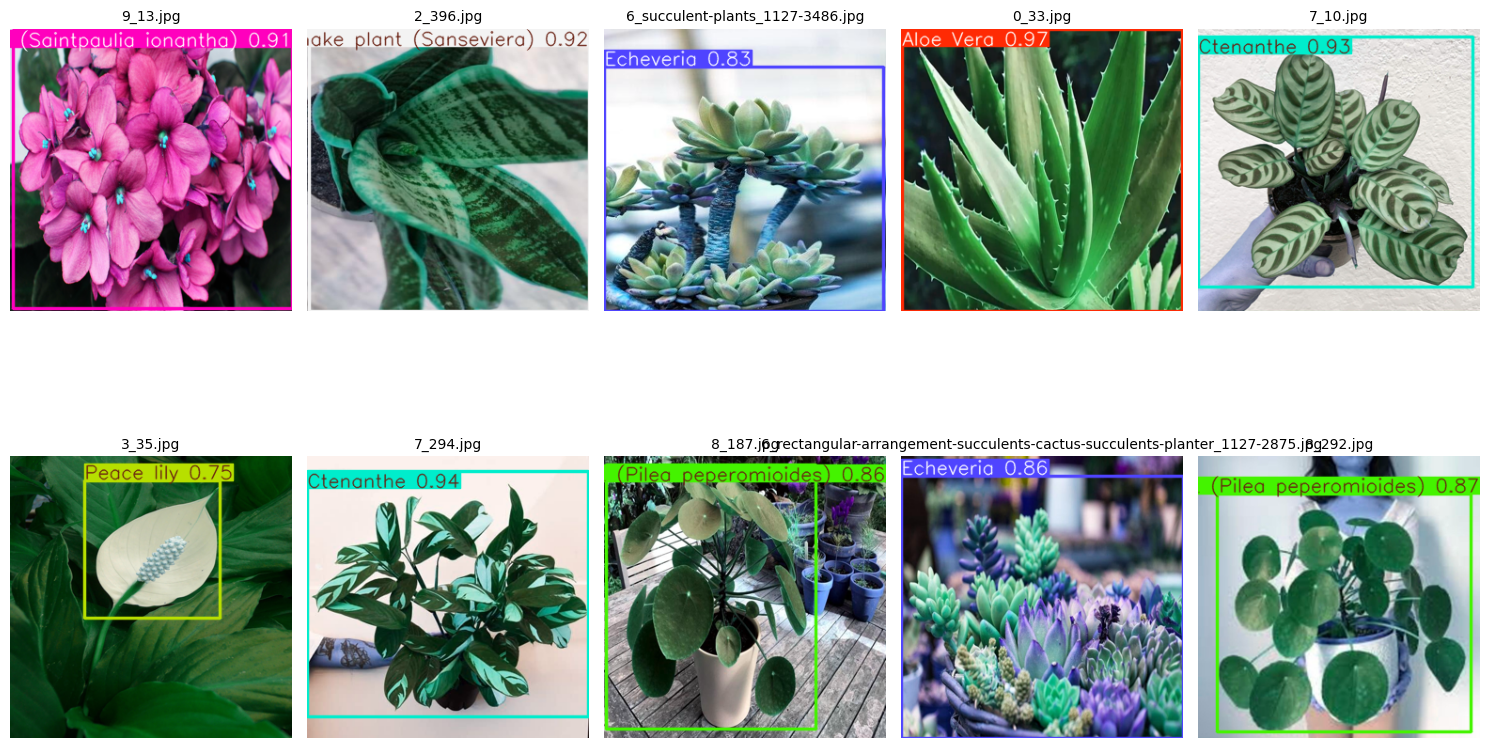

In [ ]:
# Define pyramid layout
layout = [5, 5]  # Number of images in each row (5 and 5 for a pyramid layout)
species_count = sum(layout)  # Total number of images

# Validate the layout matches the number of species
if len(sample_filenames) != species_count:
    raise ValueError(f"Mismatch between layout ({species_count} slots) and the number of species ({len(sample_filenames)}).")

# Create the plot
fig, axes = plt.subplots(len(layout), max(layout), figsize=(15, 10))
axes = axes.flatten()

# Plot each species in the pyramid layout
idx = 0
for row, images_in_row in enumerate(layout):
    for col in range(max(layout)):
        ax = axes[row * max(layout) + col]
        if col < images_in_row:
            file_name = sample_filenames[idx]
            file_path = os.path.join(VAL_IMAGES_PATH, file_name)
            image = Image.open(file_path)

            # Resize the image for consistent display
            image_resized = image.resize((300, 300))

            # Predict using YOLO model
            results = yolo_model.predict(source=image_resized, save=True, conf=0.7)

            # Display the annotated image
            ax.imshow(results[0].plot())
            ax.axis('off')
            ax.set_title(file_name, fontsize=10)
            idx += 1
        else:
            ax.axis('off')  # Turn off unused axes in the row

plt.tight_layout()
plt.show()

**Save the model**

In [ ]:
model_path = os.path.join(BASE_PATH, "plant_detection_model.pt")
yolo_model.save(model_path)

# Summary

#### **Project Overview**
The project involves building an object detection model using the YOLOv8 framework to classify 10 species of houseplants, trained on a Kaggle's houseplant species dataset. My main goal was to develop a robust model capable of accurately detecting and classifying plants, even challenging species like African Violet and Peace Lily, which underperformed and now has acceptable performance.

#### **Dataset Development**
The dataset was sourced from Kaggle's houseplant species dataset and split into training and validation subsets, ensuring diversity in plant types, lighting conditions, and perspectives.
Preprocessing and augmentations were applied to enhance dataset variability, including color adjustments, geometric transformations, and mixup augmentations.

#### **Challenges and Solutions**
During training, several challenges emerged:

* Underperforming Classes: African Violet and Peace Lily showed significantly lower recall and mAP scores.
  * Solution 1: Oversampling: Oversampled these classes slightly, introducing a controlled bias to help the model better recognize their features.
  * Solution 2: Weighted Classes: Increased class weights in the training configuration to give these classes higher importance during the loss calculation.

* Generalization Issues:
  * Applied advanced augmentation techniques (e.g., RandAugment, Mosaic, CutMix) to improve robustness and generalization across diverse real-world scenarios.

* Resource Optimization:
  * After evaluating several Google Colab GPU options, we selected the NVIDIA A100, which provided the computational power necessary to train YOLOv8 models efficiently, particularly for a larger batch size of 128.

#### **Training Results**
Achieved an overall mean Average Precision (mAP) of **0.85 on training** and **0.79 on validation** datasets.
Precision and recall were generally high for most classes (e.g., Aloe Vera, Monstera), but African Violet and Peace Lily required additional focused techniques to achieve acceptable performance.

#### **Future Improvements**
I will conclude with the note that there is always room for improvement, such as adopting a larger architecture like YOLOv8m (medium) to better capture complex features or enhancing the dataset with greater diversity and balance to improve generalization and address underperforming classes.
